In [1]:
import pandas as pd
from tqdm import tqdm
# import gensim
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from joblib import Parallel, delayed
import sys
from scipy.stats import norm

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# # 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
# tf.config.set_visible_devices([], 'GPU')

from tqdm.notebook import tqdm
tf.random.set_seed(seed_value)
import multiprocessing


No GPU found


In [3]:
import matplotlib.pyplot as plt

import pickle

In [4]:
path = os.getcwd() + "//dataset_1"

In [5]:
# ## read in all the drug features
# ## for train test and valid
train_drugs = np.load(path + "//" + "train_drug.npy")

In [6]:
idxs = list(set(range(0, train_drugs.shape[1])).difference(range(30,60)))

In [7]:
train_omics = np.load(path + "//" + "train_omics.npy")[:, idxs]

In [8]:
train_omics.shape

(500, 60)

In [9]:
train_omics1 = np.load(path + "//" + "train_omics.npy")

In [10]:
def ann(hidden = 10, input_shape = 60): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(1)
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [11]:
# X_train_word2vec = train_drugs

In [12]:
h1, h2 = 16,16

In [13]:


ann_15 = ann(h1)


# In[35]:


# ann_15.summary()


# In[36]:



In [14]:
ann_15.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60)]              0         
                                                                 
 dense (Dense)               (None, 16)                976       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


In [15]:
# X_train_word2vec = train_omics

In [16]:
ann_20 = ann(h2, 60)



# ann_20.summary()



In [17]:
total_weights_1 = ann_15.count_params()

In [18]:
total_weights_2 = ann_20.count_params()

In [19]:
total_weights = total_weights_1 + total_weights_2 + 1 

In [20]:
total_weights

1987

In [21]:
## batch size
batch_size = 128

In [22]:
# var_weights = 0.08
# var_targets = 0.08

In [23]:
from scipy.stats import multivariate_normal as mvn

In [24]:
from scipy.stats import invgamma, norm

In [25]:
from tqdm.notebook import tqdm

In [26]:
threshold = 5

In [27]:
import random

In [28]:
lr = 0.1

In [29]:
import numpy as np

In [30]:
weights_ann_1 = ann_15.get_weights()
weights_ann_2 = ann_20.get_weights()

In [31]:
def get_targets_with_weights(batch_data, batch_data1, initial_ensembles, log_sigma_points_1): 

    n_hidden_1 = len(weights_ann_1[0].ravel())

    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)

    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)



    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, 1)

    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + 1)].reshape(size_ens, 1, 1)



    final_output_1 = output_1 + output_layer_bias_1

    n_hidden_2 = len(weights_ann_2[0].ravel())

    initial_ensembles_1 = initial_ensembles.copy()[:, total_weights_1:(total_weights_1+ total_weights_2)]
    
    # print(batch_data1.shape[1])
    
    
    hidden_weights_2 = initial_ensembles_1[:,:n_hidden_2].reshape(size_ens, batch_data1.shape[1], h2)



    hidden_output_2 = np.einsum('ij,kjl->kil', batch_data1, hidden_weights_2)

    hidden_layer_bias_2 = initial_ensembles[:,n_hidden_2:(n_hidden_2 + h2)].reshape(size_ens, 1,  h2)

    hidden_output_2 = hidden_output_2+ hidden_layer_bias_2

    n_pred_weights_2 = len(weights_ann_2[2].ravel())

    output_weights_2 = initial_ensembles_1[:,(n_hidden_2 + h2):(n_hidden_2 + h2 + n_pred_weights_2) ].reshape(size_ens, h2, 1)


    output_2 = np.einsum('ijk,ikl->ijl', hidden_output_2, output_weights_2)


    output_layer_bias_2 = initial_ensembles_1[:,(n_hidden_2 + h2 + n_pred_weights_2):(n_hidden_2 + h2 + n_pred_weights_2 + 1)].reshape(size_ens, 1, 1)


    final_output_2 = output_2 + output_layer_bias_2


    weights_1 = initial_ensembles[:, :total_weights_1]

    weights_2 = initial_ensembles[:, total_weights_1:(total_weights_1 + total_weights_2)]


    avg_weights = initial_ensembles[:, -1].reshape(-1,1)

    avg_weights_sig = expit(avg_weights)
    
    avg_weights_sig = avg_weights_sig.reshape(avg_weights_sig.shape[0], 1, avg_weights_sig.shape[1])
    
    complement_weights_sig = 1 - expit(avg_weights)
    
    complement_weights_sig = complement_weights_sig.reshape(complement_weights_sig.shape[0], 1, complement_weights_sig.shape[1])

    final_output_1 = final_output_1*complement_weights_sig
    
    final_output_2 = final_output_2*avg_weights_sig
    
    output_1_ravel = final_output_1.reshape(size_ens, final_output_1.shape[1]*final_output_1.shape[2])

    output_2_ravel = final_output_2.reshape(size_ens, final_output_2.shape[1]*final_output_2.shape[2])


    output_1_ravel = output_1_ravel

    output_2_ravel = output_2_ravel



    weights_1_add = np.zeros((size_ens, (total_weights_2 - total_weights_1)))



    weights_1 = np.hstack((weights_1, weights_1_add))
    


    stack_1 = np.hstack((output_1_ravel, weights_1, np.repeat(0, size_ens).reshape(-1,1), np.repeat(0, size_ens).reshape(-1,1)))



    
    stack_2 = np.hstack((output_2_ravel, weights_2, avg_weights, log_sigma_points_1))

    
    initial_aug_state = np.hstack((stack_1, stack_2)) 
    

    return initial_aug_state , output_1_ravel, output_2_ravel, log_sigma_points_1



In [32]:
import time

In [33]:
from scipy.stats import multivariate_normal as mvn

In [34]:
var_weights =1

In [35]:
from scipy.stats import multivariate_normal as mvn

In [36]:
reduction = 15
# reduction = 10

In [37]:
shape_needed = (total_weights + 2*batch_size*1 + 1 + (total_weights_2 - total_weights_1))//reduction

In [38]:
size_ens = shape_needed

In [39]:
size_ens = int(size_ens)

In [40]:
size_ens

149

In [41]:
# train_fudged_probs

In [42]:
import matplotlib.pyplot as plt

In [43]:
from scipy.special import expit

In [44]:
# catch1[0][0]

In [45]:
# catch_train_logits_second[0]

In [46]:
from datetime import datetime

In [47]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [48]:
from scipy.stats import gamma

In [49]:
use_cores = multiprocessing.cpu_count()-1

In [50]:
use_cores

47

In [51]:
from datetime import datetime

In [52]:
from sklearn.metrics import mean_squared_error

In [53]:
import random

In [54]:
gamma_param = 500

In [55]:
from scipy import stats

In [56]:
from scipy.stats import pearsonr

In [57]:
var_targetsw = 0.02

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
from sklearn.model_selection import KFold

In [60]:
# train_drugs.shape

In [61]:
def rep_one_real_world(train_ids_f, test_ids_f): 
    catch_1 = []
    catch_2 = []
    catch_3 = []
    catch_4 = []
    catch_5 = []
#     from scipy.special import expit
    patience_smaller = 0
    patience_uns = 0
    
    
    best_valid_mae = 100000
    
    best_train_width = 100000

        
    X_train_logits_unshuffled = y_train.reshape(-1,1)[train_ids_f,:]
    train_size = X_train_logits_unshuffled.shape[0]
    
    random_idx = list(random.sample(range(0,train_size), k = int(0.1667*train_size)))
#     X_train_logits = catch_train_logits_second[idx]
    
    not_random_idx = list(set(range(0,train_size)).difference(random_idx))
    
    X_train_logits_unshuffled1 = X_train_logits_unshuffled[not_random_idx, :]
    X_valid_logits = X_train_logits_unshuffled[random_idx,:]
    X_test_logits = y_train.reshape(-1,1)[test_ids_f,:]
    
    ## create training batch chunks
    train_idx = list(range(0, len(X_train_logits_unshuffled1)))
    batch_chunks = [train_idx[i:i+batch_size] for i in range(0,len(X_train_logits_unshuffled1),batch_size)]

    ## generate some augmented variable for iteration 0
    initial_aug_state_mean = np.repeat(0, total_weights)
    initial_aug_state_mean = initial_aug_state_mean.reshape(-1,1)

    initial_aug_state_cov = var_weights*np.identity((total_weights))
    initial_ensembles = mvn(initial_aug_state_mean.reshape(initial_aug_state_mean.shape[0],), initial_aug_state_cov).rvs(size = size_ens)

    exit_iter_no_thresh = 0
    log_sigma_points_1 = (np.log(gamma(gamma_param, scale = 1/100).rvs(size_ens))).reshape(size_ens, 1)
    

#     y_train = catch_train_labels_second[idx]

#     y_valid = catch_valid_labels_second[idx]

#     y_test = catch_test_labels_second[idx]
    
    
    train_lstm = train_drugs[train_ids_f,:]
    valid_lstm = train_lstm[random_idx,:]
    train_lstm1 = train_lstm[not_random_idx,:]
    # valid_word2vec = catch[idx][7].iloc[catch_valid_idxes[idx],:].reset_index(drop = True)
    test_lstm = train_drugs[test_ids_f,:]

    pca = PCA(n_components=train_omics.shape[1])
    train_lstm1 = pca.fit_transform(train_lstm1)
    valid_lstm = pca.transform(valid_lstm)
    test_lstm = pca.transform(test_lstm)
    
    # print(train_lstm.shape)

    train_doc2vec = train_omics[train_ids_f,:]
    valid_doc2vec = train_doc2vec[random_idx,:]
    train_doc2vec1 = train_doc2vec[not_random_idx,:]
    # valid_word2vec = catch[idx][7].iloc[catch_valid_idxes[idx],:].reset_index(drop = True)
    test_doc2vec = train_omics[test_ids_f,:]
    
    

    
    # train_valid_lstm = (train_lstm)
    # train_valid_doc2vec = (train_doc2vec)
    
    # print(train_valid_lstm.shape)

    
    
    best_coverage_train = 0
    
    start = datetime.now()
    
    for iter1 in range(0,500):
        random_idx = random.sample(range(0,train_lstm1.shape[0]), train_lstm1.shape[0])
        train_valid_lstm =train_lstm1[random_idx, :]
        train_valid_doc2vec = train_doc2vec1[random_idx, :]
        X_train_logits = X_train_logits_unshuffled1[random_idx, :]

        for batch_idx in batch_chunks:
            
            batch_data = train_valid_lstm[batch_idx,:]
            # print(batch_data.shape)
            batch_data1 = train_valid_doc2vec[batch_idx,:]
            # print(batch_data1.shape)
            batch_targets = X_train_logits[batch_idx,:]
            
            # print(batch_targets.shape)
            
            # batch_targets = batch_targets.ravel().reshape(-1,1)

            column_mod_2_shape = total_weights_2 + batch_data.shape[0]*1 + 1 + 1
        
            H_t = np.hstack((np.identity(batch_targets.shape[0]), np.zeros((batch_targets.shape[0], column_mod_2_shape-batch_targets.shape[0]))))
            
            
            
            
            current_aug_state, column_mod_1, column_mod_2, log_sigma_points_1 = get_targets_with_weights(batch_data1, batch_data, initial_ensembles, log_sigma_points_1)
            
            # print(current_aug_state.shape)
            
            
            var_targets_vec = np.log(1 + np.exp(log_sigma_points_1))
            
            var_targets_vec = var_targets_vec
            
            # current_aug_state_var = np.cov(current_aug_state.T) + inflation_factor*np.identity(current_aug_state.shape[1])
            
            current_aug_state_var = np.cov(current_aug_state.T) 
            
            G_t = np.array([1 , 1]).reshape(-1,1)
            
            scirpt_H_t = np.kron(G_t.T, H_t)
            
            temp1 = current_aug_state_var@scirpt_H_t.T
            
            temp2 = scirpt_H_t@current_aug_state_var@scirpt_H_t.T

            R_t1 = var_targetsw*np.identity(current_aug_state.shape[1])
            
            measurement_error1 = mvn(np.repeat(0,current_aug_state.shape[1]), R_t1).rvs(current_aug_state.shape[0])
        
            for ensemble_idx in range(0, current_aug_state.shape[0]):
                
                var_targets1 = var_targets_vec[ensemble_idx,:]
                
                R_t = var_targets1*np.identity(batch_targets.shape[0])
            
                measurement_error = mvn(np.repeat(0,batch_targets.shape[0]), var_targets1*np.identity(batch_targets.shape[0])).rvs(1).reshape(-1,1)
            
                target_current = batch_targets + measurement_error
                
                # print(target_current.shape)
                
                K_t = temp1@np.linalg.inv(temp2 + R_t)
                
                # print(K_t.shape)

                current_aug_state[ensemble_idx,:] = current_aug_state[ensemble_idx,:] +(K_t@(target_current -scirpt_H_t@current_aug_state[ensemble_idx,:].reshape(-1,1))).reshape(current_aug_state.shape[1],)
                
                current_aug_state[ensemble_idx,:] = current_aug_state[ensemble_idx,:] + measurement_error1[ensemble_idx,:]

            weights_ann_1 = current_aug_state[:,batch_targets.shape[0]:(batch_targets.shape[0] + total_weights_1)]      

            weights_ann_2 = current_aug_state[:,-(total_weights_2+1):-2]    

            initial_ensembles = np.hstack((weights_ann_1, weights_ann_2, current_aug_state[:,-2].reshape(-1,1)))
            
            log_sigma_points_1 = current_aug_state[:,-1].reshape(-1,1)
               
            avg_betas = expit(current_aug_state[:,-2])
        
            complement = 1-avg_betas

            current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(valid_doc2vec, valid_lstm, initial_ensembles, log_sigma_points_1)
            
            initial_targets = column_mod_11 + column_mod_21
            
            
            initial_targets = initial_targets.reshape(size_ens, valid_lstm.shape[0],1)
            
            initial_targets_train = initial_targets
            
            initial_targets_train_mean = initial_targets_train.mean(0)
            
            li = np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[0,:,:]
            
            ui = np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[1,:,:]
            
            width = ui - li
            
            avg_width_valid = np.mean(width)
            
            # interim = np.vstack((catch_train_probs[idx] , catch_valid_probs[idx] ))
        
            interim = (X_valid_logits)
            
            ind = (interim >= li) & (interim <= ui)
            
            coverage_valid= np.mean(ind.ravel())  
            
            valid_mae = np.sqrt(mean_squared_error(interim, initial_targets_train_mean))
            
            stats_pearson_valid = stats.pearsonr(interim.reshape(interim.shape[0],),
                                           initial_targets_train_mean.reshape(initial_targets_train_mean.shape[0],))

            current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(train_doc2vec1, train_lstm1, initial_ensembles, log_sigma_points_1)
            
            initial_targets = column_mod_11 + column_mod_21
            
            
            initial_targets = initial_targets.reshape(size_ens, train_lstm1.shape[0],1)
            
            initial_targets_train = initial_targets
            
            initial_targets_train_mean = initial_targets_train.mean(0)
            
            li = np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[0,:,:]
            
            ui = np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[1,:,:]
            
            width = ui - li
            
            avg_width_train = np.mean(width)
            
            # interim = np.vstack((catch_train_probs[idx] , catch_valid_probs[idx] ))
        
            interim = (X_train_logits_unshuffled1)
            
            ind = (interim >= li) & (interim <= ui)
            
            coverage_train= np.mean(ind.ravel())  
            
            train_mae = np.sqrt(mean_squared_error(interim, initial_targets_train_mean))
            
            # plt.scatter(interim, initial_targets_train_mean)
            # plt.show()
            
            stats_pearson_train = stats.pearsonr(interim.reshape(interim.shape[0],),
                                           initial_targets_train_mean.reshape(initial_targets_train_mean.shape[0],))

            # train_mae = np.sqrt(np.mean(np.abs(interim.ravel() - initial_targets_train_mean.ravel())**2))
        
            current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(test_doc2vec, test_lstm, initial_ensembles, log_sigma_points_1)
            
            initial_targets = column_mod_11 + column_mod_21
            
            initial_targets = initial_targets.reshape(size_ens, test_lstm.shape[0],1)
            
            initial_targets_test = initial_targets
            
            # initial_targets_softmax = expit(initial_targets)    
            
            initial_targets_test_mean = initial_targets_test.mean(0)
            
            li = np.percentile(initial_targets_test, axis = 0, q = (2.5, 97.5))[0,:,:]
            
            ui = np.percentile(initial_targets_test, axis = 0, q = (2.5, 97.5))[1,:,:]
            
            width = ui - li
            
            avg_width = np.mean(width)
            
            catch_test_probs = (X_test_logits)
            
            ind_test = (catch_test_probs >= li) & (catch_test_probs <= ui)
                        
            coverage_test = np.mean(ind_test.ravel())    

            
            test_mae = np.sqrt(mean_squared_error(catch_test_probs, initial_targets_test_mean))

            stats_pearson = stats.pearsonr(catch_test_probs.reshape(catch_test_probs.shape[0],),
                                           initial_targets_test_mean.reshape(initial_targets_test_mean.shape[0],))

              
            
            if  valid_mae < best_valid_mae: 
                patience = 0
                best_train_mae = train_mae
                best_valid_mae = valid_mae
                best_test_mae = test_mae
                exit_iter_no_thresh = iter1
                best_test_preds = initial_targets_test
                patience_smaller = 0
                best_train_coverage = coverage_train
                best_valid_coverage = coverage_valid
                best_test_coverage = coverage_test
                best_train_width = avg_width_train
                best_valid_width = avg_width_valid
                best_test_width = avg_width
                best_drugs_weight = np.mean(complement)
                best_r_test = stats_pearson[0]
                best_r_train = stats_pearson_train[0]
                best_r_valid = stats_pearson_valid[0]
                best_initial_ensembles = initial_ensembles
                best_log_sigma_points_1 = log_sigma_points_1
                best_initial_targets_test_mean = initial_targets_test_mean
                best_li = li
                best_ui = ui
            else:
                patience += 1
                
#             print("epoch "+ str(iter1))
#             print("patience "+ str(patience))
#             print("train mae is " + str(train_mae))
#             print("valid mae is " + str(valid_mae))
#             print("test mae is " + str(test_mae))
        
#             print("train coverage is "+ str(coverage_train))
#             print("valid coverage is "+ str(coverage_valid))
#             print("test coverage is "+ str(coverage_test))
            
#             print("train width is " + str(avg_width_train))
#             print("valid width is " + str(avg_width_valid))  
#             print("test width is " + str(avg_width))
            
#             print("drugs weight is " + str(np.mean(complement)))
#             print("pearson r train is " + str(stats_pearson_train[0]))
#             print("pearson r valid is " + str(stats_pearson_valid[0]))
#             print("pearson r test is " + str(stats_pearson[0]))
            
            
                
            if patience >= threshold: 
                break
                
        if patience >= threshold: 
                break
            
    
    print(best_valid_mae, best_valid_coverage, best_valid_width,best_r_valid, flush = True)
    print(best_test_mae, best_test_coverage, best_test_width,best_r_test, flush = True)
    end = datetime.now()
    total = (end- start)
    time_taken = total.seconds/60.0
    return best_train_mae, best_valid_mae, best_test_mae, best_train_coverage, best_valid_coverage, best_test_coverage,  \
    best_train_width, best_valid_width , best_test_width,  best_drugs_weight, best_r_train, best_r_valid, best_r_test, exit_iter_no_thresh, time_taken, best_initial_ensembles, best_log_sigma_points_1, [X_test_logits.tolist(), best_initial_targets_test_mean.tolist()], [best_li.tolist(), best_ui.tolist()]
        
    # print("something went awry", flush = True)

In [62]:
threshold = 10

In [63]:
# cutoff_threshold = 30

In [64]:
# plt.hist(y_train)
# plt.show()

In [65]:
batch_size = 512

In [66]:
path = os.getcwd() + "//dataset_" + str(0 + 1) + "/"
train_drugs_1 = np.load(path + "//" + "train_drug.npy")
valid_drugs_1 = np.load(path + "//" + "valid_drug.npy")
test_drugs_1 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_1 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_1 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_1 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_1 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_1 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_1 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [67]:
path = os.getcwd() + "//dataset_" + str(1 + 1) + "/"
train_drugs_2 = np.load(path + "//" + "train_drug.npy")
valid_drugs_2 = np.load(path + "//" + "valid_drug.npy")
test_drugs_2 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_2 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_2 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_2 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_2 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_2 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_2 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [68]:
path = os.getcwd() + "//dataset_" + str(1 + 2) + "/"
train_drugs_3 = np.load(path + "//" + "train_drug.npy")
valid_drugs_3 = np.load(path + "//" + "valid_drug.npy")
test_drugs_3 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_3 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_3 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_3 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_3 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_3 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_3 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [69]:
path = os.getcwd() + "//dataset_" + str(1 + 3) + "/"
train_drugs_4 = np.load(path + "//" + "train_drug.npy")
valid_drugs_4 = np.load(path + "//" + "valid_drug.npy")
test_drugs_4 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_4 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_4 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_4 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_4 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_4 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_4 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [70]:
path = os.getcwd() + "//dataset_" + str(1 + 4) + "/"
train_drugs_5 = np.load(path + "//" + "train_drug.npy")
valid_drugs_5 = np.load(path + "//" + "valid_drug.npy")
test_drugs_5 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_5 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_5 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_5 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_5 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_5 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_5 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [71]:
path = os.getcwd() + "//dataset_" + str(1 + 5) + "/"
train_drugs_6 = np.load(path + "//" + "train_drug.npy")
valid_drugs_6 = np.load(path + "//" + "valid_drug.npy")
test_drugs_6 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_6 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_6 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_6 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_6 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_6 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_6 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [72]:
path = os.getcwd() + "//dataset_" + str(1 + 6) + "/"
train_drugs_7 = np.load(path + "//" + "train_drug.npy")
valid_drugs_7 = np.load(path + "//" + "valid_drug.npy")
test_drugs_7 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_7 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_7 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_7 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_7 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_7 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_7 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [73]:
path = os.getcwd() + "//dataset_" + str(1 + 7) + "/"
train_drugs_8 = np.load(path + "//" + "train_drug.npy")
valid_drugs_8 = np.load(path + "//" + "valid_drug.npy")
test_drugs_8 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_8 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_8 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_8 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_8 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_8 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_8 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [74]:
path = os.getcwd() + "//dataset_" + str(1 + 8) + "/"
train_drugs_9 = np.load(path + "//" + "train_drug.npy")
valid_drugs_9 = np.load(path + "//" + "valid_drug.npy")
test_drugs_9 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_9 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_9 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_9 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_9 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_9 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_9 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [75]:
path = os.getcwd() + "//dataset_" + str(1 + 9) + "/"
train_drugs_10 = np.load(path + "//" + "train_drug.npy")
valid_drugs_10 = np.load(path + "//" + "valid_drug.npy")
test_drugs_10 = np.load(path + "//" + "test_drug.npy")

## read in all the omics features
## for train test and valid
train_omics_10 = np.load(path + "//" + "train_omics.npy")[:, idxs]
valid_omics_10 = np.load(path + "//" + "valid_omics.npy")[:, idxs]
test_omics_10 = np.load(path + "//" + "test_omics.npy")[:, idxs]

## read in all the labels 
## for train test and valid
y_train_10 = np.load(path + "//" + "train_y.npy").reshape(-1,1)
y_valid_10 = np.load(path + "//" + "valid_y.npy").reshape(-1,1)
y_test_10 = np.load(path + "//" + "test_y.npy").reshape(-1,1)

In [76]:
train_drugs = np.vstack((train_drugs_1,train_drugs_2, train_drugs_3, train_drugs_4,train_drugs_5, train_drugs_6,
                        train_drugs_7,train_drugs_8, train_drugs_9, train_drugs_10))

In [77]:
train_omics = np.vstack((train_omics_1,train_omics_2, train_omics_3, train_omics_4,train_omics_5, train_omics_6, 
                        train_omics_7,train_omics_8, train_omics_9, train_omics_10))

In [78]:
valid_drugs = np.vstack((valid_drugs_1,valid_drugs_2, valid_drugs_3, valid_drugs_4,valid_drugs_5, valid_drugs_6,
                        valid_drugs_7,valid_drugs_8, valid_drugs_9, valid_drugs_10))

In [79]:
valid_omics = np.vstack((valid_omics_1,valid_omics_2, valid_omics_3, valid_omics_4,valid_omics_5, valid_omics_6, 
                        valid_omics_7,valid_omics_8, valid_omics_9, valid_omics_10))

In [80]:
test_drugs = np.vstack((test_drugs_1,test_drugs_2, test_drugs_3, test_drugs_4,test_drugs_5, test_drugs_6,
                        test_drugs_7,test_drugs_8, test_drugs_9, test_drugs_10))

In [81]:
test_omics = np.vstack((test_omics_1,test_omics_2, test_omics_3, test_omics_4,test_omics_5, test_omics_6, 
                        test_omics_7,test_omics_8, test_omics_9, test_omics_10))

In [82]:
test_omics.shape

(1000, 60)

In [83]:
y_train = np.vstack((y_train_1,y_train_2, y_train_3, y_train_4,y_train_5, y_train_6, y_train_7,y_train_8, y_train_9, y_train_10))

In [84]:
y_valid = np.vstack((y_valid_1,y_valid_2, y_valid_3, y_valid_4,y_valid_5, y_valid_6, y_valid_7,y_valid_8, y_valid_9, y_valid_10))

In [85]:
y_test = np.vstack((y_test_1,y_test_2, y_test_3, y_test_4,y_test_5, y_test_6, y_test_7,y_test_8, y_test_9, y_test_10))

In [86]:
y_train.shape

(5000, 1)

In [87]:
y_valid.shape

(1000, 1)

In [88]:
y_test.shape

(1000, 1)

In [89]:
from sklearn.decomposition import PCA

In [90]:
train_drugs = np.vstack((train_drugs, valid_drugs, test_drugs))

In [91]:
train_omics = np.vstack((train_omics, valid_omics, test_omics))

In [92]:
train_omics.shape

(7000, 60)

In [93]:
y_train = np.vstack((y_train, y_valid, y_test))

In [94]:
train_drugs.shape

(7000, 90)

In [95]:
y_train.shape

(7000, 1)

In [96]:
kf = KFold(n_splits = 7, random_state=42, shuffle = True)

In [97]:
kf.get_n_splits(train_drugs)

7

In [98]:
# kf_inner = KFold(n_splits = 6, random_state=42, shuffle = True)

In [99]:
# len(train_index)

In [100]:
train_ids = []
# valid_ids = []
test_ids = []
# test_ids = []
for i, (train_index, test_index) in enumerate(kf.split(train_drugs)): 
    train_ids.append(train_index)
    test_ids.append(test_index)

In [101]:
# len(test_ids[0])

In [102]:
# batch_size = 1000

In [103]:
# train_idx = list(range(0, len(y_train)))
# batch_chunks_train = [train_idx[i:i+batch_size] for i in range(0,len(y_train),batch_size)]

In [104]:
# np.max(batch_chunks_train[0])

In [105]:
# batch_size = 200
# valid_idx = list(range(0, len(y_valid)))
# batch_chunks_valid = [valid_idx[i:i+batch_size] for i in range(0,len(y_valid),batch_size)]

In [106]:
# len(batch_chunks_valid)

In [107]:
# train_ids

In [108]:
# best_train_mae, best_valid_mae, best_test_mae, best_train_coverage, best_valid_coverage, best_test_coverage,  \
    # best_train_width, best_valid_width , best_test_width,  best_drugs_weight, best_r_train, best_r_valid, best_r_test, exit_iter_no_thresh, time_taken, best_initial_ensembles, best_log_sigma_points_1, test_actual_preds, best_li_ui = rep_one_real_world(train_ids[4], test_ids[4])

In [109]:
# test_actual_preds[0].shape

In [110]:
# len(test_actual_preds)

In [111]:
# test_actual_preds, best_li_ui

In [112]:
from joblib import Parallel, delayed

In [143]:
# test_actual_preds[:5]

In [144]:
# best_li_ui[0]

In [145]:
catch = Parallel(n_jobs = 6, backend = "loky", verbose = 8)(delayed(rep_one_real_world)(train_ids[i], test_ids[i]) for i in range(0,kf.get_n_splits(train_drugs)))

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


1.4543044224406771 0.949 5.9200575324171005 0.752635992953908
1.500160185350277 0.948 5.927389221033946 0.7317283018783151
1.452217336320574 0.966 6.21323273410039 0.7182529984131006
1.4651911347090945 0.962 6.146939607606364 0.7136441786428928


[Parallel(n_jobs=6)]: Done   2 out of   7 | elapsed: 12.5min remaining: 31.3min


1.4409259467557418 0.959 6.420476150878656 0.7336442798224186
1.4964332021669118 0.963 6.425813925258554 0.7446494378706267


[Parallel(n_jobs=6)]: Done   3 out of   7 | elapsed: 13.8min remaining: 18.4min


1.4253445926672959 0.952 6.11121852044088 0.7207812040480517
1.319757580921485 0.967 6.158272248528577 0.7792996237838236


[Parallel(n_jobs=6)]: Done   4 out of   7 | elapsed: 13.9min remaining: 10.4min


1.373496126801722 0.977 7.302312095467863 0.7727598044294397
1.3829278306436188 0.976 7.214461552314113 0.7798609600009336


[Parallel(n_jobs=6)]: Done   5 out of   7 | elapsed: 16.3min remaining:  6.5min


1.3602248630631841 0.98 6.785308867037749 0.7414895638413996
1.438038979739774 0.967 6.72755501493763 0.7097614858170486
1.3962593149736267 0.95 5.860242129249227 0.7700670332801057
1.4070606212016052 0.96 5.809080265194777 0.7263650088135724


[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed: 21.3min remaining:    0.0s
[Parallel(n_jobs=6)]: Done   7 out of   7 | elapsed: 21.3min finished


In [146]:
with open("Preds_Mutation_Methylation_with_PCA_proper_CV" + ".pkl", 'wb') as f:
    pickle.dump(catch, f)

In [113]:
with open("Preds_Mutation_Methylation_with_PCA_proper_CV" + ".pkl", 'rb') as f:
    catch = pickle.load(f)

In [114]:
catch_df = pd.DataFrame(catch).iloc[:,:13]

In [115]:
catch_df.columns = ['best_train_mae', 'best_valid_mae', 'best_test_mae', 'best_train_coverage', 'best_valid_coverage', 'best_test_coverage',  \
    'best_train_width', 'best_valid_width' , 'best_test_width',  'best_drugs_weight', 'best_r_train', 'best_r_valid', 'best_r_test']

In [116]:
catch_df.head(10)

,best_train_mae,best_valid_mae,best_test_mae,best_train_coverage,best_valid_coverage,best_test_coverage,best_train_width,best_valid_width,best_test_width,best_drugs_weight,best_r_train,best_r_valid,best_r_test
0,1.438547,1.454304,1.500160,0.9520,0.949,0.948,5.842187,5.920058,5.927389,0.372187,0.734848,0.752636,0.731728
1,1.488994,1.452217,1.465191,0.9576,0.966,0.962,6.166375,6.213233,6.146940,0.447695,0.716676,0.718253,0.713644
2,1.407961,1.360225,1.438039,0.9736,0.980,0.967,6.804670,6.785309,6.727555,0.492838,0.766176,0.741490,0.709761
3,1.366491,1.373496,1.382928,0.9764,0.977,0.976,7.164960,7.302312,7.214462,0.511371,0.760522,0.772760,0.779861
4,1.428198,1.440926,1.496433,0.9648,0.959,0.963,6.420204,6.420476,6.425814,0.409509,0.751158,0.733644,0.744649
5,1.368751,1.425345,1.319758,0.9624,0.952,0.967,6.136636,6.111219,6.158272,0.469375,0.767829,0.720781,0.779300
6,1.374859,1.396259,1.407061,0.9632,0.950,0.960,5.750893,5.860242,5.809080,0.439153,0.759418,0.770067,0.726365


In [117]:
catch_df['best_drugs_weight'] = 1 - catch_df['best_drugs_weight']

In [118]:
catch_df.mean()

best_train_mae         1.410543
best_valid_mae         1.414682
best_test_mae          1.429939
best_train_coverage    0.964286
best_valid_coverage    0.961857
best_test_coverage     0.963286
best_train_width       6.326561
best_valid_width       6.373264
best_test_width        6.344216
best_drugs_weight      0.551125
best_r_train           0.750947
best_r_valid           0.744233
best_r_test            0.740758
dtype: float64

In [153]:
# pca = PCA(n_components = test_omics.shape[1])
# pca.fit(train_drugs)

In [154]:
# test_drugs = pca.transform(test_drugs)

In [155]:
# test_drugs.shape

In [136]:
preds_test_catch = []
test_catch = []
li_catch = []
ui_catch = []
for i in range(0,7):
    preds = catch[i][-2][1]
    actual = catch[i][-2][0]
    preds_test_catch.append(preds)
    test_catch.append(actual)
#     best_log_sigma_points_1 = catch[i][-3]
#     current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(test_omics, test_drugs, params, best_log_sigma_points_1)
            
#     initial_targets_test = column_mod_11 + column_mod_21
            
#     initial_targets_test = initial_targets_test.reshape(size_ens, test_omics.shape[0],1)
            
#     initial_targets_test_mean = initial_targets_test.mean(0)
    
    # preds_test_catch.append(preds)
    
    li = catch[i][-1][0]
    li_catch.append(li)
            
    ui = catch[i][-1][1]
    ui_catch.append(ui)
            
#     width = ui - li
            
#     avg_width = np.mean(width)

In [215]:
# len(preds_test_catch)

In [137]:
len(preds_test_catch)

7

In [120]:
preds_test_catch = [inner for item in preds_test_catch for inner in item]

In [138]:
test_catch = [inner for item in test_catch for inner in item]

In [139]:
li_catch =  [inner for item in li_catch for inner in item]

In [140]:
ui_catch =  [inner for item in ui_catch for inner in item]

In [161]:
# avg_width

In [162]:
# y_test_preds = np.array(preds_test_catch).mean(0)

In [163]:
# y_test_preds.shape

In [141]:
li = np.array(li_catch).reshape(-1,1)

In [142]:
ui = np.array(ui_catch).reshape(-1,1)

In [143]:
y_test = np.array(test_catch).reshape(-1,1)

In [144]:
ind_test = (y_test >= li) & (y_test <= ui)

In [168]:
# ind_test.mean()

In [145]:
width = np.array(ui_catch) - np.array(li_catch)

In [146]:
np.mean(width)

6.344215976410566

In [147]:
y_test_preds = np.array(preds_test_catch).reshape(-1,1)

In [148]:
y_test = np.array(test_catch).reshape(-1,1)

In [149]:
np.sqrt(mean_squared_error(y_test, y_test_preds))

1.4312134276122617

In [150]:
pearsonr(y_test[:,0], y_test_preds[:,0])[0]

0.7375440977970815

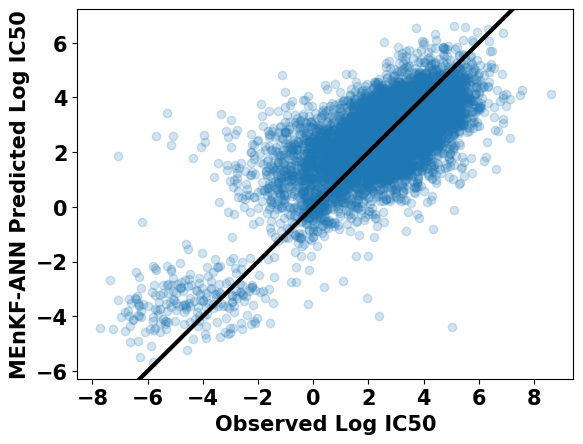

In [151]:
fig  = plt.figure()
plt.scatter(y_test[:,0], y_test_preds[:,0], alpha = 0.2)
plt.axline((0,0), slope = 1, c = "black", linewidth = 3)
plt.xlabel("Observed Log IC50", fontweight = "bold", fontsize = 15)
plt.ylabel("MEnKF-ANN Predicted Log IC50", fontweight = "bold", fontsize = 15)
plt.xticks(fontsize = 15, fontweight = "bold")
plt.yticks(fontsize = 15, fontweight = "bold")
fig.savefig('Plots/Scatter_Test_With_PCA_proper_CV.pdf', bbox_inches='tight', format = "pdf")
fig.savefig('Plots/Scatter_Test_With_PCA_proper_CV.png', bbox_inches='tight')
plt.show()

In [176]:
# ui

In [177]:
# current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(test_omics, test_drugs, best_initial_ensembles, best_log_sigma_points_1)
            
# initial_targets = column_mod_11 + column_mod_21
            
# initial_targets = initial_targets.reshape(size_ens, test_omics.shape[0],1)
            
# initial_targets_test = initial_targets

In [178]:
# # initial_targets_softmax = expit(initial_targets)    
            
# initial_targets_test_mean = initial_targets_test.mean(0)
            
# li = np.percentile(initial_targets_test, axis = 0, q = (2.5, 97.5))[0,:,:]
            
# ui = np.percentile(initial_targets_test, axis = 0, q = (2.5, 97.5))[1,:,:]
            
# width = ui - li
            
# avg_width = np.mean(width)
            
# catch_test_probs = (y_test)
            
# ind_test = (catch_test_probs >= li) & (catch_test_probs <= ui)
                        
# coverage_test = np.mean(ind_test.ravel())    

            
# test_mae = np.sqrt(mean_squared_error(catch_test_probs, initial_targets_test_mean))

# stats_pearson = stats.pearsonr(catch_test_probs.reshape(catch_test_probs.shape[0],),
#                                            initial_targets_test_mean.reshape(initial_targets_test_mean.shape[0]))

In [179]:
# stats_pearson

In [180]:
# string = "Real_World_EnKF_DeepCDR_" + "Neurons_" + str(h1)  + "_Gamma_" +  str(gamma_param) +  "_var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens)

In [181]:
# string = "First_Three_Real_World_EnKF_DeepCDR_" + "Neurons_" + str(h1)  + "_Gamma_" +  str(gamma_param) +  "_var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens)

In [182]:
# string

In [183]:
# catch_coverages = [best_train_mae, best_valid_mae, best_test_mae, best_train_coverage, best_test_coverage, best_valid_coverage, best_test_coverage, \
#     best_train_width, best_valid_width , best_test_width, best_drugs_weight, best_r_train, best_r_valid, best_r, exit_iter_no_thresh, time_taken, best_initial_ensembles, best_log_sigma_points_1]

In [184]:
# best_train_mae, best_valid_mae, best_test_mae, best_train_coverage, best_test_coverage, best_valid_coverage, best_test_coverage, \
#     best_train_width, best_valid_width , best_test_width, (1-best_drugs_weight), best_r_train, best_r_valid, best_r, exit_iter_no_thresh, time_taken, best_initial_ensembles, best_log_sigma_points_1

In [185]:
# with open("Preds_Mutation_Methylation" + ".pkl", 'wb') as f:
#     pickle.dump(catch_coverages, f)

In [186]:
# fig  = plt.figure()
# plt.scatter(y_test, initial_targets_test_mean, alpha = 0.5)
# plt.axline((0,0), slope = 1, c = "black", linewidth = 3)
# plt.xlabel("Observed Log IC50", fontweight = "bold", fontsize = 15)
# plt.ylabel("MEnKF-ANN Predicted Log IC50", fontweight = "bold", fontsize = 15)
# plt.xticks(fontsize = 15, fontweight = "bold")
# plt.yticks(fontsize = 15, fontweight = "bold")
# fig.savefig('Plots/Avg_Smile_Weight_Tajectory.pdf', bbox_inches='tight', format = "pdf")
# fig.savefig('Plots/Avg_Smile_Weight_Tajectory.png', bbox_inches='tight')
# plt.show()

In [187]:
# catch_coverages

In [188]:
# catch_coverages

In [189]:
# check = pd.DataFrame(catch_coverages[:10])

In [190]:
# check

In [191]:
# check

In [192]:
# check.columns = ["train_mae", "test_mae", "avg_ci_width_train", "avg_ci_width_test", "avg_lstm_weight", "exit_iter", "exit_status"]

In [193]:
# check = check.T


In [194]:
# check

In [195]:
# check.columns = ["train_mae", "test_mae", "train_coverage", "train_width", "test_coverage", "test_width", "exit_iter", "time_taken", "avg_width_alginate"]

In [196]:
# check.columns = ["train_mae", "test_mae", "train_coverage", "train_width", "test_coverage", "test_width", "drug_weight" , "pearson_correlation" ,"exit_iter", "time_taken"]

In [197]:
# true_preds = [inner for item in true_preds for inner in item]

In [198]:
# enkf_preds = [inner for item in enkf_preds for inner in item]

In [199]:
# np.mean(np.abs(np.array(true_preds)-np.array(enkf_preds)))

In [200]:
# plt.scatter(enkf_preds,true_preds, alpha=0.5)
# plt.xlabel("EnKF Predictions", fontsize = 15, fontweight = "bold")
# plt.ylabel("LSTM Predictions", fontsize = 15, fontweight = "bold")
# plt.xticks( fontsize = 10, fontweight = "bold")
# plt.yticks( fontsize = 10, fontweight = "bold")
# plt.axline((0, 0), slope=1)
# plt.show()

In [201]:
# cur_idx = 0

In [202]:
# catch_preds = []
# for i in range(0, catch_coverages[cur_idx][-1].shape[1]):
#     enkf_preds = catch_coverages[cur_idx][-1][:,i,:]
#     enkf_preds_df = pd.DataFrame(enkf_preds)
#     enkf_preds_df["Test_Sample_ID"] = i 
#     enkf_preds_df.columns = ["EnKF_Preds", "Test_Sample_ID"]
#     catch_preds.append(enkf_preds_df)

In [203]:
# catch_preds_df = pd.concat(catch_preds)

In [204]:
# import seaborn as sns

In [205]:
# filtered_df = expit(catch1[cur_idx][2])

In [206]:
# # plt.figure(figsize = (10,10))
# fig = sns.boxplot(catch_preds_df, x="Test_Sample_ID", y="EnKF_Preds", showfliers=False)
# plt.scatter(range(0, filtered_df.shape[0]), filtered_df, c = "black", s = 50)
# plt.xlabel("Test Sample ID", fontsize = 15, fontweight = "bold")
# plt.ylabel("EnKF Predictions", fontsize = 15, fontweight = "bold")
# plt.xticks(fontsize = 10, fontweight = "bold")
# plt.yticks(fontsize = 10, fontweight = "bold")
# plt.show()

In [207]:
# ids = [i for i in range(0, filtered_df.shape[0]) if filtered_df[i] < 0.5]
# ids_more = [i for i in range(0, filtered_df.shape[0]) if filtered_df[i] > 0.5]

In [208]:
# catch_preds_df.groupby("Test_Sample_ID").quantile(q = [0.025, 0.975])

In [209]:
# catch_preds_df_filtered = catch_preds_df[catch_preds_df["Test_Sample_ID"].isin(ids_more)]

In [210]:
# filtered_true = filtered_df[ids_more,:]

In [211]:
# # plt.figure(figsize = (10,10))
# fig = sns.boxplot(catch_preds_df_filtered, x="Test_Sample_ID", y="EnKF_Preds", showfliers=False)
# plt.scatter(range(0, filtered_true.shape[0]), filtered_true, c = "black", s = 50)
# plt.xlabel("Test Sample ID", fontsize = 15, fontweight = "bold")
# plt.ylabel("EnKF Predictions", fontsize = 15, fontweight = "bold")
# plt.xticks(fontsize = 10, fontweight = "bold")
# plt.yticks(fontsize = 10, fontweight = "bold")
# plt.show()

In [212]:
# catch_preds_df_filtered = catch_preds_df[catch_preds_df["Test_Sample_ID"].isin(ids)]
# filtered_true = filtered_df[ids,:]
# # plt.figure(figsize = (10,10))
# fig = sns.boxplot(catch_preds_df_filtered, x="Test_Sample_ID", y="EnKF_Preds", showfliers=False)
# plt.scatter(range(0, filtered_true.shape[0]), filtered_true, c = "black")
# plt.xlabel("Test Sample ID", fontsize = 15, fontweight = "bold")
# plt.ylabel("EnKF Predictions", fontsize = 15, fontweight = "bold")
# plt.xticks(fontsize = 10, fontweight = "bold")
# plt.yticks(fontsize = 10, fontweight = "bold")
# plt.show()
# # plt.ylim((0.9,1.0))